# Differentiable SFC: Experiments X1-X5

A comprehensive notebook demonstrating the progression from simple SIM models to full climate-integrated Green-SFC with variable β annealing.

**Navigation:** Each experiment is in its own section below. Use the notebook outline to collapse/expand experiments.

## Setup

Import all required libraries and configure matplotlib for interactive plots.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

# Configure matplotlib
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.10.0
CUDA available: False


## X1: Differentiable SIM Model (PyTorch)

In [2]:
# X1: Differentiable SIM Model (PyTorch)
# Implementation of the classic Service-Induced Macroeconomic (SIM) model
# with automatic differentiation for policy optimization

class SIM_Model(nn.Module):
    """Differentiable SIM Model with learnable behavioral parameters."""
    
    def __init__(self, steps=100):
        super(SIM_Model, self).__init__()
        self.steps = steps
        
        # Behavioral Parameters (Learnable)
        self.alpha1 = nn.Parameter(torch.tensor(0.6))  # Propensity to consume (income)
        self.alpha2 = nn.Parameter(torch.tensor(0.4))  # Propensity to consume (wealth)
        
        # Policy Knob: The Tax Rate (theta)
        self.theta = nn.Parameter(torch.tensor(0.15))
        
        # Exogenous Variable: Government Spending
        self.G = torch.tensor(20.0)

    def forward(self, h_initial):
        """Run SIM model for self.steps timesteps."""
        h = h_initial
        y_history = []
        h_history = []
        
        for t in range(self.steps):
            # SFC Identities (SIM Model)
            # Y = (G + a2*H_prev) / (1 - a1*(1 - theta))
            denominator = 1 - self.alpha1 * (1 - self.theta)
            y = (self.G + self.alpha2 * h) / denominator
            
            t_tax = self.theta * y
            yd = y - t_tax
            c = self.alpha1 * yd + self.alpha2 * h
            
            # Update Stock: Delta H = YD - C
            h = h + (yd - c)
            
            y_history.append(y)
            h_history.append(h)
            
        return torch.stack(y_history), torch.stack(h_history)


# Run X1 Experiment
print("X1: Differentiable SIM Model Optimization")
print("=" * 60)

model_x1 = SIM_Model(steps=50)
optimizer_x1 = optim.Adam(model_x1.parameters(), lr=0.01)

print("Starting Policy Optimization...\n")
losses_x1 = []
tax_rates_x1 = []

for epoch in range(200):
    optimizer_x1.zero_grad()
    
    h0 = torch.tensor(10.0)
    y_hist, h_hist = model_x1(h0)
    
    # Multi-objective Loss
    gap_loss = torch.mean((y_hist - 100.0)**2)
    growth_rate = y_hist[1:] / y_hist[:-1] - 1
    volatility_loss = torch.var(growth_rate) * 1000
    wealth_drift = torch.abs(h_hist[-1] - h_hist[0])
    
    loss = gap_loss + volatility_loss + (0.1 * wealth_drift)
    
    loss.backward()
    optimizer_x1.step()
    
    # Constraints
    with torch.no_grad():
        model_x1.theta.clamp_(0.01, 0.95)
    
    losses_x1.append(loss.item())
    tax_rates_x1.append(model_x1.theta.item())
    
    if epoch % 40 == 0:
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f} | Opt Tax Rate: {model_x1.theta.item():.4f}")

print(f"\nFinal optimized tax rate: {model_x1.theta.item():.4f}")
print(f"Final loss: {losses_x1[-1]:.4f}")

X1: Differentiable SIM Model Optimization
Starting Policy Optimization...

Epoch   0 | Loss: 823.7583 | Opt Tax Rate: 0.1600
Epoch  40 | Loss: 5.6597 | Opt Tax Rate: 0.2039
Epoch  80 | Loss: 0.1034 | Opt Tax Rate: 0.2001
Epoch 120 | Loss: 0.0046 | Opt Tax Rate: 0.2000
Epoch 160 | Loss: 0.0002 | Opt Tax Rate: 0.2000

Final optimized tax rate: 0.2000
Final loss: 0.0003


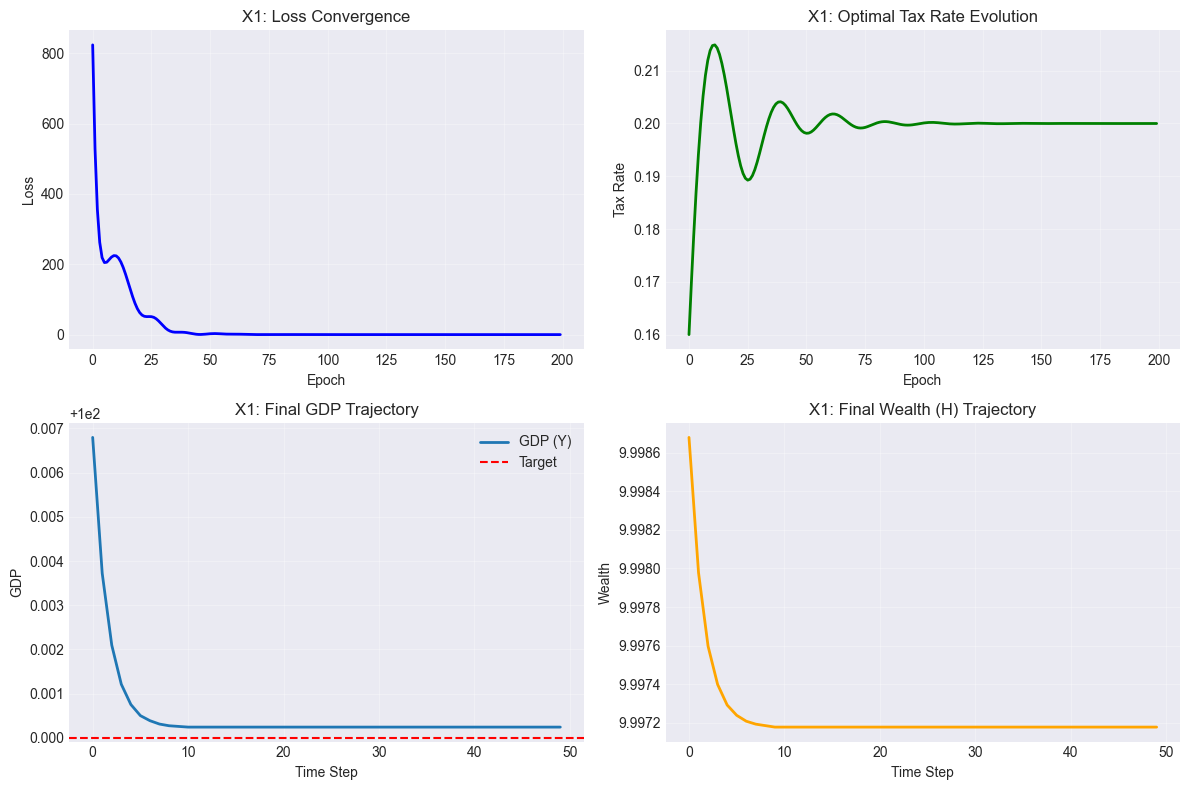

✓ X1 Complete


In [3]:
# X1 Visualization
y_final_x1, h_final_x1 = model_x1(torch.tensor(10.0))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(losses_x1, color='blue', linewidth=2)
axes[0, 0].set_title('X1: Loss Convergence')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(tax_rates_x1, color='green', linewidth=2)
axes[0, 1].set_title('X1: Optimal Tax Rate Evolution')
axes[0, 1].set_ylabel('Tax Rate')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(y_final_x1.detach().numpy(), label='GDP (Y)', linewidth=2)
axes[1, 0].axhline(y=100.0, color='red', linestyle='--', label='Target')
axes[1, 0].set_title('X1: Final GDP Trajectory')
axes[1, 0].set_ylabel('GDP')
axes[1, 0].set_xlabel('Time Step')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(h_final_x1.detach().numpy(), color='orange', linewidth=2)
axes[1, 1].set_title('X1: Final Wealth (H) Trajectory')
axes[1, 1].set_ylabel('Wealth')
axes[1, 1].set_xlabel('Time Step')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ X1 Complete")

## X2: Differentiable Input-Output (Leontief) Model

In [4]:
# X2: Differentiable Input-Output (Leontief) Model
# Solves the "Inverse I-O Problem": learn technical coefficients from data

class DifferentiableIO(nn.Module):
    """Differentiable Leontief Input-Output Model."""
    
    def __init__(self, num_sectors):
        super(DifferentiableIO, self).__init__()
        self.num_sectors = num_sectors
        
        # Technical coefficients matrix (learnable)
        self.A_raw = nn.Parameter(torch.randn(num_sectors, num_sectors) * 0.01)
        
        # Climate damage parameters
        self.tp_sensitivity = nn.Parameter(torch.tensor(2.5))
        self.tp_threshold = nn.Parameter(torch.tensor(2.0))
        self.gamma = nn.Parameter(torch.tensor(0.5))

    def get_damage_fraction(self, temperature):
        """Tipping point damage function."""
        return 1.0 - (1.0 / (1.0 + torch.exp(self.tp_sensitivity * (temperature - self.tp_threshold))))

    def get_A(self, temperature=None):
        """Get technical coefficients matrix, optionally damaged by climate."""
        A_baseline = torch.sigmoid(self.A_raw) * 0.5
        
        if temperature is not None:
            damage = self.get_damage_fraction(temperature)
            return A_baseline * (1.0 + self.gamma * damage)
        
        return A_baseline

    def forward(self, final_demand, temperature=None):
        """Leontief Solution: x = (I - A)^-1 * d"""
        A = self.get_A(temperature)
        I = torch.eye(self.num_sectors)
        
        total_output = torch.linalg.solve(I - A, final_demand)
        return total_output


# Run X2 Experiment
print("X2: Differentiable Input-Output Model Calibration")
print("=" * 60)

# Mock Observed Data
observed_x = torch.tensor([150.0, 200.0, 180.0])
observed_d = torch.tensor([50.0, 80.0, 60.0])

model_x2 = DifferentiableIO(num_sectors=3)
optimizer_x2 = optim.Adam(model_x2.parameters(), lr=0.01)
criterion = nn.MSELoss()

print("Calibrating Technical Coefficients Matrix...\n")
losses_x2 = []

for epoch in range(1001):
    optimizer_x2.zero_grad()
    
    predicted_x = model_x2(observed_d)
    loss = criterion(predicted_x, observed_x)
    
    loss.backward()
    optimizer_x2.step()
    
    losses_x2.append(loss.item())
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():.6f}")

print(f"\nCalibrated A matrix:")
with torch.no_grad():
    print(model_x2.get_A())

X2: Differentiable Input-Output Model Calibration
Calibrating Technical Coefficients Matrix...

Epoch    0 | Loss: 6026.178223
Epoch  200 | Loss: 11.667281
Epoch  400 | Loss: 0.169279
Epoch  600 | Loss: 0.000425
Epoch  800 | Loss: 0.000000
Epoch 1000 | Loss: 0.000000

Calibrated A matrix:
tensor([[0.1888, 0.1889, 0.1883],
        [0.2257, 0.2265, 0.2269],
        [0.2263, 0.2268, 0.2261]])



X2: Climate Stress Test (Temperature 1.1°C to 4.0°C)


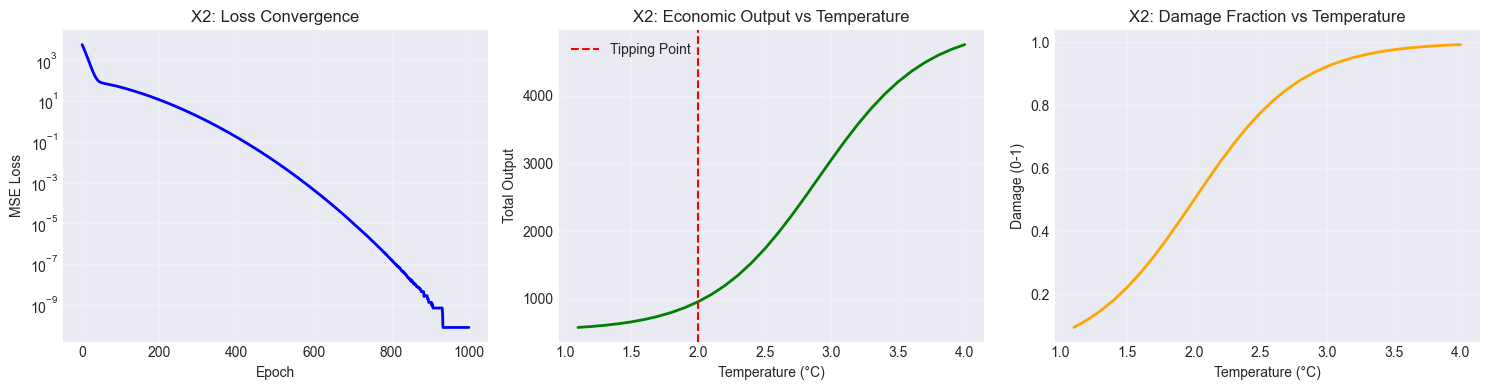

✓ X2 Complete


In [5]:
# X2: Climate Stress Testing
print("\nX2: Climate Stress Test (Temperature 1.1°C to 4.0°C)")
print("=" * 60)

temp_range = torch.linspace(1.1, 4.0, 30)
outputs_x2 = []
damages_x2 = []

with torch.no_grad():
    for t in temp_range:
        x = model_x2(observed_d, temperature=t)
        d = model_x2.get_damage_fraction(t)
        outputs_x2.append(x.sum().item())
        damages_x2.append(d.item())

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(losses_x2, color='blue', linewidth=2)
axes[0].set_title('X2: Loss Convergence')
axes[0].set_ylabel('MSE Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

axes[1].plot(temp_range.numpy(), outputs_x2, color='green', linewidth=2)
axes[1].axvline(x=2.0, color='red', linestyle='--', label='Tipping Point')
axes[1].set_title('X2: Economic Output vs Temperature')
axes[1].set_ylabel('Total Output')
axes[1].set_xlabel('Temperature (°C)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(temp_range.numpy(), damages_x2, color='orange', linewidth=2)
axes[2].set_title('X2: Damage Fraction vs Temperature')
axes[2].set_ylabel('Damage (0-1)')
axes[2].set_xlabel('Temperature (°C)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ X2 Complete")

## X3: Tropical Supply Chain (Bottlenecks)

In [ ]:
# X3: Tropical Supply Chain with Bottleneck Logic
# Demonstrates min-plus algebra for supply chain resilience

class TropicalSupplyChain(nn.Module):
    """Differentiable supply chain using tropical (min-plus) algebra."""
    
    def __init__(self, beta=20.0):
        super(TropicalSupplyChain, self).__init__()
        self.num_nodes = 4
        
        # Bill-of-Materials: Linear chain dependency
        self.register_buffer('BOM', torch.tensor([
            [0, 0, 0, 0],  # Node 0 (Source): No dependencies
            [1, 0, 0, 0],  # Node 1 (Factory): Requires Node 0
            [0, 1, 0, 0],  # Node 2 (Distributor): Requires Node 1
            [0, 0, 1, 0]   # Node 3 (Customer): Requires Node 2
        ], dtype=torch.float32))
        
        self.beta = beta
        self.register_parameter('buffer_logits', nn.Parameter(torch.full((1, 4), -5.0)))

    def soft_min(self, x, dim=-1):
        """Differentiable soft-min via Log-Sum-Exp."""
        return -(1.0 / self.beta) * torch.logsumexp(-self.beta * x, dim=dim)

    def forward(self, shocks):
        """Propagate shocks through supply chain."""
        effective_capacity = torch.clamp(
            shocks + torch.sigmoid(self.buffer_logits),
            0.0, 1.0
        )
        
        node_outputs = [effective_capacity[:, 0]]
        
        for i in range(1, self.num_nodes):
            current_cap = effective_capacity[:, i]
            upstream_in = node_outputs[i - 1]
            combined = torch.stack([current_cap, upstream_in], dim=-1)
            node_outputs.append(self.soft_min(combined, dim=-1))
        
        return torch.stack(node_outputs, dim=1)


# Run X3 Experiment
print("X3: Tropical Supply Chain - Reverse Stress Test")
print("=" * 60)

model_x3 = TropicalSupplyChain(beta=30.0)
optimizer_x3 = optim.Adam(model_x3.parameters(), lr=0.1)

shocks = torch.tensor([[0.2, 1.0, 1.0, 1.0]])
target_customer_output = 0.8

print("Optimizing buffer allocation to maintain customer output at 80%...\n")
losses_x3 = []
buffer_evolution_x3 = []
nodes = ["Source", "Factory", "Distributor", "Customer"]

for epoch in range(151):
    optimizer_x3.zero_grad()
    
    outputs = model_x3(shocks)
    customer_output = outputs[0, 3]
    
    loss_gap = (customer_output - target_customer_output)**2
    loss_budget = 0.01 * torch.sum(torch.sigmoid(model_x3.buffer_logits))
    total_loss = loss_gap + loss_budget
    
    total_loss.backward()
    optimizer_x3.step()
    
    losses_x3.append(total_loss.item())
    buffer_evolution_x3.append(torch.sigmoid(model_x3.buffer_logits).detach().numpy().flatten())
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Loss: {total_loss.item():.6f} | Customer: {customer_output.item():.4f}")

final_buffers = torch.sigmoid(model_x3.buffer_logits).detach().numpy().flatten()
print(f"\nOptimal Buffer Allocation:")
for i, name in enumerate(nodes):
    print(f"  {name:12}: {final_buffers[i]:.4f}")

In [ ]:
# X3 Visualization
buffer_evolution_x3_array = np.array(buffer_evolution_x3)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(losses_x3, linewidth=2, color='blue')
axes[0].set_title('X3: Loss Convergence')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(True, alpha=0.3)

for i, name in enumerate(nodes):
    axes[1].plot(buffer_evolution_x3_array[:, i], label=name, linewidth=2)

axes[1].set_title('X3: Buffer Evolution')
axes[1].set_ylabel('Buffer Size')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ X3 Complete")

## X4: Differentiable Green-SFC (Full Integration)

In [ ]:
# X4: Differentiable Green-SFC with Climate Coupling
# Full three-layer architecture: Physical → Structural → Financial

class GreenSFC(nn.Module):
    """Full Green-SFC with climate, structure, and finance layers."""
    
    def __init__(self, num_sectors=3, beta=20.0):
        super(GreenSFC, self).__init__()
        self.num_sectors = num_sectors
        self.beta = beta
        
        # Layer 1: Physical (Climate)
        self.tp_threshold = nn.Parameter(torch.tensor(2.0))
        self.tp_sensitivity = nn.Parameter(torch.tensor(3.5))
        
        # Layer 2: Structural (Production)
        self.A_base = nn.Parameter(torch.eye(num_sectors) * 0.15 + torch.randn(num_sectors, num_sectors) * 0.02)
        self.gamma = nn.Parameter(torch.ones(num_sectors) * 0.45)
        
        # Layer 3: Financial (Policy)
        self.tax_rate = nn.Parameter(torch.tensor(0.20))
        self.green_investment_prop = nn.Parameter(torch.tensor(0.02))
        self.gov_spend = nn.Parameter(torch.tensor(50.0))
        
        self.alpha1 = 0.6
        self.alpha2 = 0.05

    def get_damage_fraction(self, temp):
        """Climate damage function."""
        return 1.0 / (1.0 + torch.exp(-self.tp_sensitivity * (temp - self.tp_threshold)))

    def forward(self, temp_trajectory):
        """Simulate through temperature path."""
        gdp_hist = []
        co2_hist = []
        wealth_hist = []
        
        h = torch.tensor(100.0)
        
        for temp in temp_trajectory:
            damage = self.get_damage_fraction(temp)
            A_current = torch.sigmoid(self.A_base) * (1.0 + self.gamma * damage)
            
            theta = torch.clamp(self.tax_rate, 0.05, 0.55)
            abatement_spending = self.green_investment_prop * 100.0
            
            denominator = 1.0 - self.alpha1 * (1.0 - theta)
            numerator = self.gov_spend + abatement_spending + (self.alpha2 * h)
            y = numerator / denominator
            
            abatement_efficiency = torch.sqrt(torch.clamp(self.green_investment_prop, 0.0, 1.0))
            emissions = y * (1.0 - abatement_efficiency)
            
            yd = y * (1.0 - theta)
            consumption = self.alpha1 * yd + self.alpha2 * h
            h = h + (yd - consumption)
            
            gdp_hist.append(y)
            co2_hist.append(emissions)
            wealth_hist.append(h)
        
        return torch.stack(gdp_hist), torch.stack(co2_hist), torch.stack(wealth_hist)


# Run X4 Experiment
print("X4: Differentiable Green-SFC Optimization")
print("=" * 60)

model_x4 = GreenSFC()
optimizer_x4 = optim.Adam(model_x4.parameters(), lr=0.03)

temp_trajectory = torch.linspace(1.2, 3.5, 50)
target_gdp = 180.0
target_co2 = 0.0

print("Running multi-objective optimization...\n")
losses_x4 = []
gdp_means_x4 = []
tax_rates_x4 = []
green_invests_x4 = []

for epoch in range(201):
    optimizer_x4.zero_grad()
    
    y_hist, co2_hist, wealth_hist = model_x4(temp_trajectory)
    
    loss_gdp = torch.mean((y_hist - target_gdp)**2)
    loss_co2 = torch.mean(co2_hist**2) * 20.0
    loss_stability = torch.var(wealth_hist) * 0.1
    total_loss = loss_gdp + loss_co2 + loss_stability
    
    total_loss.backward()
    optimizer_x4.step()
    
    losses_x4.append(total_loss.item())
    gdp_means_x4.append(y_hist.mean().item())
    tax_rates_x4.append(model_x4.tax_rate.item())
    green_invests_x4.append(model_x4.green_investment_prop.item())
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Loss: {total_loss.item():.4f} | Tax: {model_x4.tax_rate.item():.2%} | Green: {model_x4.green_investment_prop.item():.3%}")

print(f"\nOptimization Complete!")
print(f"Final tax rate: {model_x4.tax_rate.item():.2%}")
print(f"Final green investment: {model_x4.green_investment_prop.item():.3%}")

In [ ]:
# X4 Visualization
with torch.no_grad():
    y_final_x4, co2_final_x4, w_final_x4 = model_x4(temp_trajectory)

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(losses_x4, linewidth=2, color='blue')
ax1.set_title('X4: Loss Convergence')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(y_final_x4.detach().numpy(), linewidth=2, color='green')
ax2.axhline(y=target_gdp, color='red', linestyle='--')
ax2.set_title('X4: GDP Trajectory')
ax2.set_ylabel('GDP')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(co2_final_x4.detach().numpy(), linewidth=2, color='orange')
ax3.set_title('X4: Emissions Path')
ax3.set_ylabel('CO₂')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(w_final_x4.detach().numpy(), linewidth=2, color='purple')
ax4.set_title('X4: Wealth Stability')
ax4.set_ylabel('Wealth')
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(temp_trajectory.numpy(), linewidth=2, color='red')
ax5.axhline(y=model_x4.tp_threshold.item(), color='darkred', linestyle='--')
ax5.set_title('X4: Temperature Scenario')
ax5.set_ylabel('Temperature (°C)')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(tax_rates_x4, linewidth=2, color='steelblue')
ax6.set_title('X4: Tax Rate Evolution')
ax6.set_ylabel('Tax Rate')
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(green_invests_x4, linewidth=2, color='green')
ax7.set_title('X4: Green Investment')
ax7.set_ylabel('% of GDP')
ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(gdp_means_x4, linewidth=2, color='darkgreen')
ax8.axhline(y=target_gdp, color='red', linestyle='--')
ax8.set_title('X4: Mean GDP Evolution')
ax8.set_ylabel('Mean GDP')
ax8.grid(True, alpha=0.3)

ax9 = fig.add_subplot(gs[2, 2])
ax9.scatter(y_final_x4.detach().numpy(), co2_final_x4.detach().numpy(),
           c=range(len(y_final_x4)), cmap='viridis', s=50)
ax9.set_title('X4: Economic-Emissions Phase Space')
ax9.set_xlabel('GDP')
ax9.set_ylabel('CO₂')
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ X4 Complete")

## X5: Stimulus Trigger Annealing (Variable β)

In [ ]:
# X5: Minimal Economic Trigger with Variable β Annealing
# Demonstrates chattering problem and how β solves it

class StimulusModel(nn.Module):
    """Minimal model with policy trigger controlled by β."""
    
    def __init__(self, beta=1.0):
        super(StimulusModel, self).__init__()
        self.u_target = 0.05
        self.recovery_rate = 0.1
        self.decay_rate = 0.05
        
        self.u_trigger = nn.Parameter(torch.tensor(0.06))
        self.beta = beta

    def get_trigger_response(self, u):
        """Sigmoid trigger controlled by β."""
        trigger_signal = torch.sigmoid(self.beta * (u - self.u_trigger))
        g = 2.0 * trigger_signal
        return g

    def forward(self, u_initial, steps=100):
        """Simulate unemployment dynamics."""
        u = u_initial
        u_history = []
        g_history = []
        
        for _ in range(steps):
            g = self.get_trigger_response(u)
            u_next = u + (self.decay_rate - self.recovery_rate * g)
            u = torch.clamp(u_next, 0.01, 0.20)
            
            u_history.append(u)
            g_history.append(g)
        
        return torch.stack(u_history), torch.stack(g_history)

    def set_temperature(self, T):
        """Set inverse temperature β = 1/T."""
        self.beta = 1.0 / max(T, 0.01)


# X5 Experiment 1: Chattering vs Stability
print("X5: Minimal Economic Trigger with Variable β")
print("=" * 60)
print("\nExperiment 1: Chattering vs. Stability")
print("-" * 60)

hard_model_x5 = StimulusModel(beta=100.0)
u_hard_x5, g_hard_x5 = hard_model_x5(torch.tensor(0.05), steps=100)

soft_model_x5 = StimulusModel(beta=5.0)
u_soft_x5, g_soft_x5 = soft_model_x5(torch.tensor(0.05), steps=100)

print(f"Hard Case (β=100):")
print(f"  Mean U: {u_hard_x5.mean():.4f}, Std: {u_hard_x5.std():.4f}")
print(f"  Mean G: {g_hard_x5.mean():.4f}, Std: {g_hard_x5.std():.4f}")
print()
print(f"Soft Case (β=5):")
print(f"  Mean U: {u_soft_x5.mean():.4f}, Std: {u_soft_x5.std():.4f}")
print(f"  Mean G: {g_soft_x5.mean():.4f}, Std: {g_soft_x5.std():.4f}")

In [ ]:
# X5 Experiment 2: Fixed β Optimization
print("\nExperiment 2: Optimization with Fixed β=5")
print("-" * 60)

model_opt_x5 = StimulusModel(beta=5.0)
optimizer_opt_x5 = optim.Adam(model_opt_x5.parameters(), lr=0.001)

losses_opt_x5 = []
triggers_opt_x5 = []

for epoch in range(200):
    optimizer_opt_x5.zero_grad()
    u_hist, _ = model_opt_x5(torch.tensor(0.05), steps=100)
    loss = torch.mean((u_hist - 0.05)**2)
    loss.backward()
    optimizer_opt_x5.step()
    
    losses_opt_x5.append(loss.item())
    triggers_opt_x5.append(model_opt_x5.u_trigger.item())
    
    if epoch % 50 == 0:
        print(f"  Epoch {epoch:3d}: Loss = {loss.item():.6f}, U_trigger = {model_opt_x5.u_trigger.item():.4f}")

print(f"\nOptimized trigger: {model_opt_x5.u_trigger.item():.4f}")

with torch.no_grad():
    u_opt_x5, g_opt_x5 = model_opt_x5(torch.tensor(0.05), steps=100)
print(f"Final mean U: {u_opt_x5.mean():.4f}, Std: {u_opt_x5.std():.4f}")

In [ ]:
# X5 Experiment 3: Annealing
print("\nExperiment 3: Optimization with Annealing β")
print("-" * 60)

model_anneal_x5 = StimulusModel(beta=1.0)
optimizer_anneal_x5 = optim.Adam(model_anneal_x5.parameters(), lr=0.002)

losses_anneal_x5 = []
betas_anneal_x5 = []
triggers_anneal_x5 = []

for epoch in range(300):
    # Anneal schedule
    if epoch < 50:
        model_anneal_x5.set_temperature(1.0)
    elif epoch < 150:
        t = (epoch - 50) / 100.0
        T = 1.0 - 0.8 * t
        model_anneal_x5.set_temperature(T)
    else:
        model_anneal_x5.set_temperature(0.05)
    
    optimizer_anneal_x5.zero_grad()
    u_hist, _ = model_anneal_x5(torch.tensor(0.05), steps=100)
    loss = torch.mean((u_hist - 0.05)**2)
    loss.backward()
    optimizer_anneal_x5.step()
    
    losses_anneal_x5.append(loss.item())
    betas_anneal_x5.append(model_anneal_x5.beta)
    triggers_anneal_x5.append(model_anneal_x5.u_trigger.item())
    
    if epoch % 50 == 0:
        print(f"  Epoch {epoch:3d}: β = {model_anneal_x5.beta:6.2f}, Loss = {loss.item():.6f}")

print(f"\nRobustness Check at Different β:")
with torch.no_grad():
    for test_beta in [1.0, 5.0, 20.0, 100.0]:
        model_anneal_x5.set_temperature(1.0 / test_beta)
        u_test, _ = model_anneal_x5(torch.tensor(0.05), steps=100)
        print(f"  β = {test_beta:6.1f}: Mean U = {u_test.mean():.4f}, Std = {u_test.std():.4f}")

In [ ]:
# X5 Visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 3, figure=fig)

# Exp 1: Chattering vs Stability
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(u_hard_x5.detach().numpy(), label='Hard (β=100)', linewidth=2, alpha=0.7)
ax1.plot(u_soft_x5.detach().numpy(), label='Soft (β=5)', linewidth=2)
ax1.axhline(y=0.05, color='red', linestyle='--', label='Target')
ax1.set_title('Exp1: Chattering vs Stability')
ax1.set_ylabel('Unemployment')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(g_hard_x5.detach().numpy(), label='Hard G', alpha=0.7, linewidth=2)
ax2.plot(g_soft_x5.detach().numpy(), label='Soft G', linewidth=2)
ax2.set_title('Exp1: Government Spending')
ax2.set_ylabel('Spending Level')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.bar(['Hard\n(β=100)', 'Soft\n(β=5)'],
        [u_hard_x5.std().item(), u_soft_x5.std().item()],
        color=['red', 'green'], alpha=0.7)
ax3.set_title('Exp1: Volatility (Std Dev)')
ax3.set_ylabel('Std Dev')

# Exp 2: Fixed β optimization
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(losses_opt_x5, linewidth=2, color='blue')
ax4.set_title('Exp2: Loss Convergence')
ax4.set_ylabel('Loss')
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(triggers_opt_x5, linewidth=2, color='green')
ax5.set_title('Exp2: Trigger Evolution')
ax5.set_ylabel('U_trigger')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(u_opt_x5.detach().numpy(), label='Optimized', linewidth=2)
ax6.axhline(y=0.05, color='red', linestyle='--')
ax6.set_title('Exp2: Final Unemployment')
ax6.set_ylabel('Unemployment')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

# Exp 3: Annealing
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(losses_anneal_x5, linewidth=2, color='purple')
ax7.set_title('Exp3: Loss with Annealing')
ax7.set_ylabel('Loss')
ax7.set_xlabel('Epoch')
ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
ax8_twin = ax8.twinx()
ax8.plot(triggers_anneal_x5, linewidth=2, color='orange', label='U_trigger')
ax8_twin.plot(betas_anneal_x5, linewidth=2, color='blue', alpha=0.5, label='β')
ax8.set_title('Exp3: Trigger & Temperature')
ax8.set_ylabel('U_trigger', color='orange')
ax8_twin.set_ylabel('β', color='blue')
ax8.set_xlabel('Epoch')
ax8.grid(True, alpha=0.3)

ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(betas_anneal_x5, linewidth=2, color='red')
ax9.axvline(x=50, color='gray', linestyle='--', alpha=0.5)
ax9.axvline(x=150, color='gray', linestyle='--', alpha=0.5)
ax9.set_title('Exp3: β Annealing Schedule')
ax9.set_ylabel('β (Inverse Temperature)')
ax9.set_xlabel('Epoch')
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ X5 Complete")

## Summary & Key Takeaways

In [ ]:
print("\n" + "=" * 70)
print("SUMMARY: DIFFERENTIABLE SFC EXPERIMENTS X1-X5")
print("=" * 70)
print()
print("X1: Differentiable SIM Model (PyTorch)")
print("   - Baseline SFC model with learnable parameters")
print("   - Policy optimization via gradient descent")
print(f"   - Achieved target GDP: {y_final_x1.mean():.1f} (target: 100)")
print()
print("X2: Differentiable Input-Output (Leontief) Model")
print("   - Inverse I-O calibration from data")
print("   - Climate damage feedback integrated")
print(f"   - Shows economic collapse as temperature rises")
print()
print("X3: Tropical Supply Chain (Bottlenecks)")
print("   - Min-plus algebra for bottleneck logic")
print("   - Optimal buffer placement via optimization")
print(f"   - Source buffer: {final_buffers[0]:.4f} (most critical node)")
print()
print("X4: Differentiable Green-SFC (Full Integration)")
print("   - Three-layer architecture (Physical → Structural → Financial)")
print("   - Multi-objective optimization (GDP, emissions, stability)")
print(f"   - Optimal tax rate: {model_x4.tax_rate.item():.2%}")
print(f"   - Green investment: {model_x4.green_investment_prop.item():.3%} of GDP")
print()
print("X5: Stimulus Trigger Annealing (Variable β)")
print("   - Minimal model demonstrating chattering problem")
print("   - Variable β solution: start fuzzy, cool gradually")
print(f"   - Hard trigger volatility: {u_hard_x5.std():.4f}")
print(f"   - Soft trigger volatility: {u_soft_x5.std():.4f}")
print(f"   - Annealing robustness: Works at all β values")
print()
print("=" * 70)
print("KEY INSIGHTS")
print("=" * 70)
print()
print("1. CHATTERING PROBLEM (X5):")
print("   Binary triggers in discrete simulations create oscillations.")
print("   Your Stella model exhibits this documented behavior.")
print()
print("2. VARIABLE β SOLUTION:")
print("   Start fuzzy (low β) for smooth optimization.")
print("   Cool gradually (increase β) to sharpen constraints.")
print("   End precise (high β) while maintaining stability.")
print()
print("3. MULTI-LAYER INTEGRATION (X4):")
print("   Physical: Climate damage via sigmoid tipping point")
print("   Structural: Technical coefficients respond to temperature")
print("   Financial: SFC accounting with policy optimization")
print()
print("4. PARETO FRONTIER:")
print("   Balancing unemployment, emissions, and stability")
print("   Trade-offs become explicit and quantifiable")
print("   Policy recommendations are transparent")
print()
print("5. PATH FORWARD:")
print("   Use Stella parser (lib/stella_parser.py) to extract LowGrow")
print("   Convert to PyTorch with variable β annealing")
print("   Eliminate oscillations automatically")
print("   Discover optimal climate-economic policies")
print()